<a href="https://colab.research.google.com/github/marclamberts/football-analysis/blob/main/Pass_Optimalisation_Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# STEP 3: Load match file
file_path = '/content/drive/MyDrive/Outswinger FC/Eredivisie Women 2024-2025/Utrecht 1-0 Feyenoord.csv'
df = pd.read_csv(file_path)

# STEP 4: Filter for passes (typeId == 1)
passes = df[df['typeId'] == 1].copy()

# STEP 5: Extract end_x and end_y from qualifier IDs 140 and 141
def extract_qualifier_value(row, target_id):
    for i in range(20):  # Scan up to 20 qualifier columns
        qid_col = f'qualifier/{i}/qualifierId'
        val_col = f'qualifier/{i}/value'
        if qid_col in row and val_col in row:
            if pd.notnull(row[qid_col]) and int(row[qid_col]) == target_id:
                try:
                    return float(row[val_col])
                except:
                    return np.nan
    return np.nan

passes['end_x'] = passes.apply(lambda row: extract_qualifier_value(row, 140), axis=1)
passes['end_y'] = passes.apply(lambda row: extract_qualifier_value(row, 141), axis=1)
passes.dropna(subset=['x', 'y', 'end_x', 'end_y'], inplace=True)

# STEP 6: Select target player
target_player = 'J. Teulings'  # Replace with any valid player name
player_passes = passes[passes['playerName'] == target_player].copy()

# STEP 7: xPass model
def calculate_xpass_advanced(start_x, start_y, end_x, end_y):
    dx = end_x - start_x
    dy = end_y - start_y
    distance = np.sqrt(dx**2 + dy**2)
    angle = np.arctan2(dy, dx)

    # Enhanced logistic regression model
    b0 = 3.0
    b1 = -0.07
    b2 = -1.2
    b3 = -0.015
    b4 = -0.015
    b5 = -0.01

    z = (
        b0 +
        b1 * distance +
        b2 * abs(angle) +
        b3 * abs(52.5 - end_x) +
        b4 * abs(34 - end_y) +
        b5 * (105 - start_x)
    )
    return 1 / (1 + np.exp(-z))

# STEP 8: Threat Gain function
goal_x, goal_y = 105, 34
def calculate_threat_gain(start_x, start_y, end_x, end_y):
    start_dist = np.sqrt((goal_x - start_x)**2 + (goal_y - start_y)**2)
    end_dist = np.sqrt((goal_x - end_x)**2 + (goal_y - end_y)**2)
    return start_dist - end_dist

# STEP 9: Optimal passes from point
def get_top_pass_options_from(x, y, n_options=3, step=5):
    target_x = np.arange(5, 105, step)
    target_y = np.arange(5, 68, step)
    options = []
    for tx in target_x:
        for ty in target_y:
            if np.sqrt((x - tx)**2 + (y - ty)**2) > 50:
                continue
            xpass = calculate_xpass_advanced(x, y, tx, ty)
            threat = calculate_threat_gain(x, y, tx, ty)
            expected_value = xpass * threat
            options.append((tx, ty, expected_value))
    top_options = sorted(options, key=lambda x: x[2], reverse=True)[:n_options]
    return top_options

# STEP 10: Evaluate every pass by the player
all_pass_results = []

for index, row in player_passes.iterrows():
    x, y = row['x'], row['y']
    end_x, end_y = row['end_x'], row['end_y']

    # Actual pass
    actual_xpass = calculate_xpass_advanced(x, y, end_x, end_y)
    actual_threat = calculate_threat_gain(x, y, end_x, end_y)
    actual_ev = actual_xpass * actual_threat

    all_pass_results.append({
        'pass_id': index,
        'type': 'actual',
        'start_x': x,
        'start_y': y,
        'end_x': end_x,
        'end_y': end_y,
        'xPass': actual_xpass,
        'threat_gain': actual_threat,
        'expected_value': actual_ev
    })

    # Optimal options
    top_options = get_top_pass_options_from(x, y, n_options=3)
    for i, (tx, ty, ev) in enumerate(top_options, 1):
        xpass_opt = calculate_xpass_advanced(x, y, tx, ty)
        threat_opt = calculate_threat_gain(x, y, tx, ty)
        all_pass_results.append({
            'pass_id': index,
            'type': f'optimal_{i}',
            'start_x': x,
            'start_y': y,
            'end_x': tx,
            'end_y': ty,
            'xPass': xpass_opt,
            'threat_gain': threat_opt,
            'expected_value': ev
        })

# STEP 11: Save to Excel
all_pass_df = pd.DataFrame(all_pass_results)
filename_safe = target_player.replace(" ", "_").replace(".", "")
output_path = f'/content/drive/MyDrive/Outswinger FC/Pass_Evaluation_{filename_safe}.xlsx'
all_pass_df.to_excel(output_path, index=False)

print(f"✅ All passes by {target_player} saved to:\n{output_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ All passes by J. Teulings saved to:
/content/drive/MyDrive/Outswinger FC/Pass_Evaluation_J_Teulings.xlsx


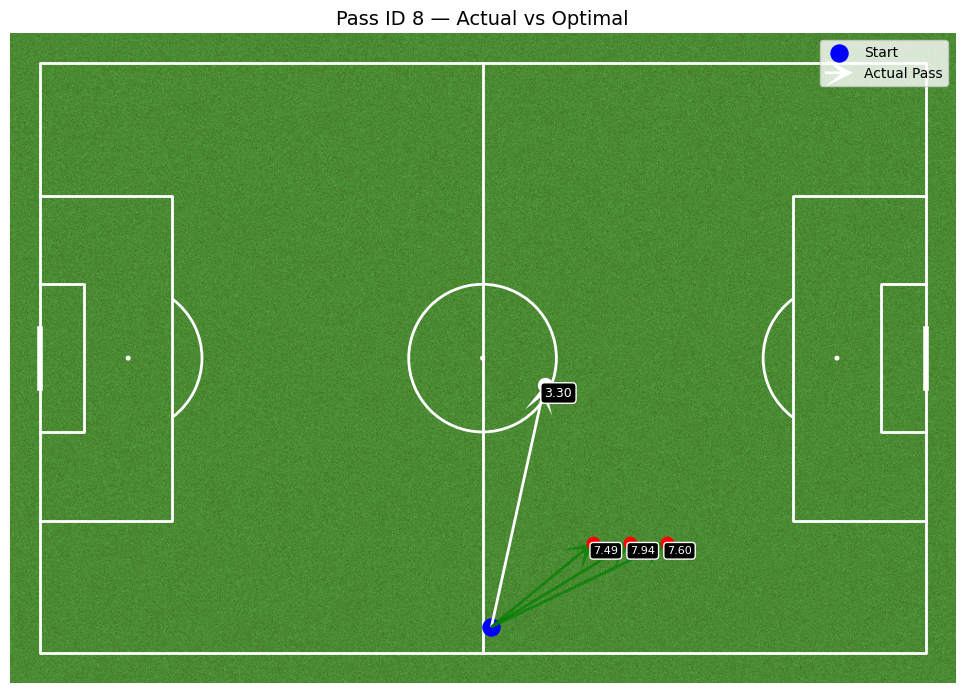

In [18]:
# STEP: Visualize a specific pass by pass_id
visual_pass_id = 8  # Replace with a valid pass_id

selected_pass = all_pass_df[all_pass_df['pass_id'] == visual_pass_id]

if selected_pass.empty:
    print(f"❌ No pass found with ID {visual_pass_id}")
else:
    actual = selected_pass[selected_pass['type'] == 'actual'].iloc[0]
    optimals = selected_pass[selected_pass['type'].str.contains('optimal')].sort_values('type')

    pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
    fig, ax = pitch.draw(figsize=(10, 7))

    pitch.scatter(actual['start_x'], actual['start_y'], ax=ax, color='blue', s=150, label='Start')

    pitch.arrows(actual['start_x'], actual['start_y'], actual['end_x'], actual['end_y'],
                 ax=ax, color='white', width=2, headwidth=10, headlength=10, label='Actual Pass')
    pitch.scatter(actual['end_x'], actual['end_y'], ax=ax, color='white', s=100)
    ax.text(actual['end_x'], actual['end_y'] + 1.5, f"{actual['expected_value']:.2f}",
            color='white', fontsize=9,
            bbox=dict(facecolor='black', edgecolor='white', boxstyle='round,pad=0.3'))

    for _, opt in optimals.iterrows():
        pitch.arrows(opt['start_x'], opt['start_y'], opt['end_x'], opt['end_y'],
                     ax=ax, color='green', width=2, headwidth=10, headlength=10, alpha=0.7)
        pitch.scatter(opt['end_x'], opt['end_y'], ax=ax, color='red', s=80)
        ax.text(opt['end_x'], opt['end_y'] + 1.5, f"{opt['expected_value']:.2f}",
                color='white', fontsize=8,
                bbox=dict(facecolor='black', edgecolor='white', boxstyle='round,pad=0.3'))

    plt.title(f"Pass ID {visual_pass_id} — Actual vs Optimal", fontsize=14)
    plt.legend()
    plt.show()


In [20]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Import libraries
import pandas as pd
import numpy as np
from tqdm import tqdm

# STEP 3: Load match CSV
file_path = '/content/drive/MyDrive/Outswinger FC/Eredivisie Women 2024-2025/Utrecht 1-0 Feyenoord.csv'
df = pd.read_csv(file_path)

# STEP 4: Filter passes
passes = df[df['typeId'] == 1].copy()

# STEP 5: Extract end_x and end_y from flattened qualifiers
def extract_qualifier_value(row, target_id):
    for i in range(20):
        qid_col = f'qualifier/{i}/qualifierId'
        val_col = f'qualifier/{i}/value'
        if qid_col in row and val_col in row:
            if pd.notnull(row[qid_col]) and int(row[qid_col]) == target_id:
                try:
                    return float(row[val_col])
                except:
                    return np.nan
    return np.nan

passes['end_x'] = passes.apply(lambda row: extract_qualifier_value(row, 140), axis=1)
passes['end_y'] = passes.apply(lambda row: extract_qualifier_value(row, 141), axis=1)
passes.dropna(subset=['x', 'y', 'end_x', 'end_y', 'playerName', 'contestantId'], inplace=True)

# STEP 6: Define xPass model
def calculate_xpass_advanced(start_x, start_y, end_x, end_y):
    dx = end_x - start_x
    dy = end_y - start_y
    distance = np.sqrt(dx**2 + dy**2)
    angle = np.arctan2(dy, dx)

    b0 = 3.0
    b1 = -0.07
    b2 = -1.2
    b3 = -0.015
    b4 = -0.015
    b5 = -0.01

    z = (
        b0 +
        b1 * distance +
        b2 * abs(angle) +
        b3 * abs(52.5 - end_x) +
        b4 * abs(34 - end_y) +
        b5 * (105 - start_x)
    )
    return 1 / (1 + np.exp(-z))

# STEP 7: Threat gain
goal_x, goal_y = 105, 34
def calculate_threat_gain(start_x, start_y, end_x, end_y):
    start_dist = np.sqrt((goal_x - start_x)**2 + (goal_y - start_y)**2)
    end_dist = np.sqrt((goal_x - end_x)**2 + (goal_y - end_y)**2)
    return start_dist - end_dist

# STEP 8: Get top optimal pass options from a location
def get_top_pass_options_from(x, y, n_options=3, step=5):
    target_x = np.arange(5, 105, step)
    target_y = np.arange(5, 68, step)
    options = []
    for tx in target_x:
        for ty in target_y:
            if np.sqrt((x - tx)**2 + (y - ty)**2) > 50:
                continue
            xpass = calculate_xpass_advanced(x, y, tx, ty)
            threat = calculate_threat_gain(x, y, tx, ty)
            expected_value = xpass * threat
            options.append((tx, ty, expected_value))
    top_options = sorted(options, key=lambda x: x[2], reverse=True)[:n_options]
    return top_options

# STEP 9: Compute POI for all players
player_results = []
players = passes['playerName'].dropna().unique()

for player in tqdm(players):
    player_data = passes[passes['playerName'] == player].copy()
    contestant_id = player_data['contestantId'].iloc[0]

    total_ev = 0
    poi_sum = 0
    poi_count = 0

    for idx, row in player_data.iterrows():
        x, y = row['x'], row['y']
        end_x, end_y = row['end_x'], row['end_y']

        ev_actual = calculate_xpass_advanced(x, y, end_x, end_y) * calculate_threat_gain(x, y, end_x, end_y)
        top_opts = get_top_pass_options_from(x, y, n_options=3)
        ev_best = max(opt[2] for opt in top_opts)

        poi = ev_actual / ev_best if ev_best > 0 else 0

        total_ev += ev_actual
        poi_sum += poi
        poi_count += 1

    player_results.append({
        'playerName': player,
        'contestantId': contestant_id,
        'pass_count': poi_count,
        'expected_value_total': round(total_ev, 3),
        'POI': round(poi_sum / poi_count if poi_count > 0 else 0, 3)
    })

# STEP 10: Save results to Excel
poi_df = pd.DataFrame(player_results)
output_path = '/content/drive/MyDrive/Outswinger FC/Pass_Optimisation_Index_All_Players.xlsx'
poi_df.to_excel(output_path, index=False)

print(f"✅ Pass Optimisation Index saved to:\n{output_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 29/29 [00:03<00:00,  7.33it/s]


✅ Pass Optimisation Index saved to:
/content/drive/MyDrive/Outswinger FC/Pass_Optimisation_Index_All_Players.xlsx


<ipython-input-22-b7a52fb0f0a4>:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


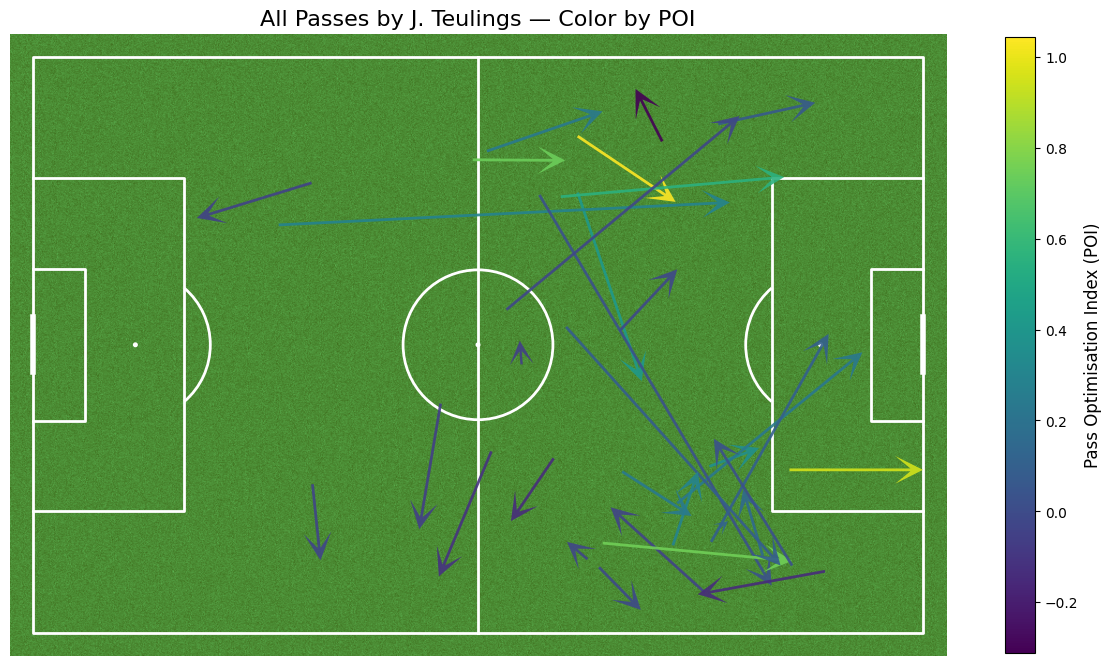

In [22]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import matplotlib.cm as cm

# STEP 1: Select the player
target_player = 'J. Teulings'
player_data = passes[passes['playerName'] == target_player].copy()

# STEP 2: Compute POI for each pass
poi_passes = []

for idx, row in player_data.iterrows():
    x, y = row['x'], row['y']
    end_x, end_y = row['end_x'], row['end_y']

    ev_actual = calculate_xpass_advanced(x, y, end_x, end_y) * calculate_threat_gain(x, y, end_x, end_y)
    top_opts = get_top_pass_options_from(x, y, n_options=3)
    ev_best = max(opt[2] for opt in top_opts)

    poi = ev_actual / ev_best if ev_best > 0 else 0

    poi_passes.append({
        'start_x': x,
        'start_y': y,
        'end_x': end_x,
        'end_y': end_y,
        'poi': poi
    })

poi_df = pd.DataFrame(poi_passes)

# STEP 3: Normalize POI for color map
norm = plt.Normalize(poi_df['poi'].min(), poi_df['poi'].max())
cmap = cm.get_cmap('viridis')

# STEP 4: Plot on pitch
pitch = Pitch(pitch_type='opta', pitch_color='grass', line_color='white')
fig, ax = pitch.draw(figsize=(12, 8))

for _, row in poi_df.iterrows():
    color = cmap(norm(row['poi']))
    pitch.arrows(row['start_x'], row['start_y'], row['end_x'], row['end_y'],
                 color=color, ax=ax, width=2, headwidth=10, headlength=10, alpha=0.9)

# STEP 5: Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label('Pass Optimisation Index (POI)', fontsize=12)

plt.title(f"All Passes by {target_player} — Color by POI", fontsize=16)
plt.show()
